In [36]:
import numpy as np
import pandas as pd

import itertools
import xgboost

In [37]:
matches = pd.read_csv('data/matches_enhanced.csv', sep=',', decimal='.')

In [55]:
#matches.sort_values(by='home_team').home_team.unique()

In [38]:
ranking = pd.read_csv('data/ranking/fifa_ranking-2021-05-27.csv')

In [39]:
h_matches = matches.copy(deep=True)
a_matches = matches.copy(deep=True)

In [40]:
h_matches['outcome'] = h_matches.apply(lambda x: 'win' if x.home_score>x.away_score else 'lose' if x.home_score<x.away_score else 'draw', axis=1)

In [41]:
a_matches['home_team'] = matches['away_team'] 
a_matches['away_team'] = matches['home_team'] 
a_matches['home_score'] = matches['away_score'] 
a_matches['away_score'] = matches['home_score'] 
a_matches['home_rank'] = matches['away_rank'] 
a_matches['away_rank'] = matches['home_rank'] 

In [42]:
a_matches['outcome'] = a_matches.apply(lambda x: 'win' if x.home_score>x.away_score else 'lose' if x.home_score<x.away_score else 'draw', axis=1)

In [9]:
h_matches.head()

,Unnamed: 0,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,home_rank,away_rank,outcome
0,17505,1993-01-02,Gabon,Burkina Faso,1,1,Friendly,Libreville,Gabon,False,55,97,draw
1,17506,1993-01-02,Kuwait,Lebanon,2,0,Friendly,Kuwait City,Kuwait,False,71,161,win
2,17507,1993-01-03,Burkina Faso,Mali,1,0,Friendly,Libreville,Gabon,True,97,69,win
3,17508,1993-01-03,Gabon,Ghana,2,3,Friendly,Libreville,Gabon,False,55,39,lose
4,17509,1993-01-08,Uganda,Tanzania,3,1,Friendly,Kampala,Uganda,False,92,80,win


In [10]:
a_matches.head()

,Unnamed: 0,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,home_rank,away_rank,outcome
0,17505,1993-01-02,Burkina Faso,Gabon,1,1,Friendly,Libreville,Gabon,False,97,55,draw
1,17506,1993-01-02,Lebanon,Kuwait,0,2,Friendly,Kuwait City,Kuwait,False,161,71,lose
2,17507,1993-01-03,Mali,Burkina Faso,0,1,Friendly,Libreville,Gabon,True,69,97,lose
3,17508,1993-01-03,Ghana,Gabon,3,2,Friendly,Libreville,Gabon,False,39,55,win
4,17509,1993-01-08,Tanzania,Uganda,1,3,Friendly,Kampala,Uganda,False,80,92,lose


In [43]:
matches_all = pd.concat([h_matches, a_matches])

In [44]:
predictors = ['home_team', 'away_team', 'home_rank', 'away_rank']
X = matches_all[predictors]
y = matches_all['outcome']

X = pd.get_dummies(X)

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=17)

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

clf = XGBClassifier()

params = {
    'n_estimators' : [100],
    'max_depth' : [2],
    'booster' : ['gbtree'],
    'subsample' : [.4],
    'colsample_bytree' : [.8]
}

model = GridSearchCV(clf, param_grid=params, scoring='roc_auc_ovr', cv=5)

model.fit(X_train, y_train)
print(model.best_params_)

In [18]:
from xgboost import XGBClassifier

# model
model = XGBClassifier(n_estimators=100, 
                      max_depth=2, 
                      booster='gbtree', 
                      subsample=.4, 
                      colsample_bytree=.8)
model.fit(X_train, y_train)


[09:52:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=0.4,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
import pickle

pickle_out = open('model_xgb_ODC_pickle__20220322.pkl', 'wb')

pickle.dumps(model, pickle_out)
pickle_out.close()

In [46]:
#meta_model

In [164]:
cols = X.columns

a_country = 'Morocco'
h_country = 'Nigeria'
    
df = pd.DataFrame(np.zeros((1,len(cols)), dtype=int), columns=cols)

In [165]:
try:
    df.home_rank.iloc[0] = ranking[((ranking.rank_date == '2021-05-27') & (ranking.country_full == h_country))]['rank'].values[0]
except:
    df.home_rank.iloc[0] = 155

try:
    df.away_rank.iloc[0] = ranking[((ranking.rank_date == '2021-05-27') & (ranking.country_full == a_country))]['rank'].values[0]
except:
    df.away_rank.iloc[0] = 155

In [166]:
df['home_team_'+h_country].iloc[0] = 1
df['away_team_'+a_country].iloc[0] = 1

In [167]:
model.predict(df.iloc[0].to_numpy().reshape(1,130))[0]

'win'

In [168]:
model.predict_proba(df.iloc[0].to_numpy().reshape(1,130))[0]

array([0.20532097, 0.22901006, 0.565669  ], dtype=float32)

In [169]:
model.predict(X.values)

array(['lose', 'lose', 'win', ..., 'win', 'win', 'lose'], dtype=object)

In [170]:
model.predict_proba(X.values)

array([[0.3125035 , 0.35086736, 0.33662915],
       [0.24062343, 0.5775389 , 0.18183766],
       [0.3185098 , 0.26596972, 0.41552052],
       ...,
       [0.20247072, 0.13430706, 0.66322225],
       [0.3124157 , 0.3312507 , 0.3563336 ],
       [0.2137174 , 0.4400482 , 0.3462344 ]], dtype=float32)

In [26]:
from sklearn.metrics import multilabel_confusion_matrix

cm = multilabel_confusion_matrix(y.values, model.predict(onehot_df.values))

C:\Users\DevPC\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


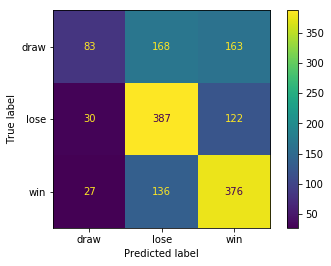

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model, onehot_df.values, y.values)

auc : 72.72%


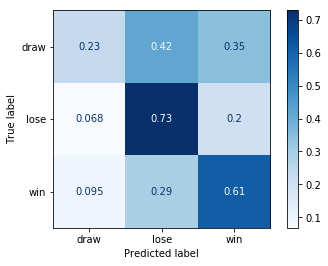

In [112]:
ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, normalize='true', cmap='Blues')
print('auc : {0:.2%}'.format(roc_auc_score(y_train, model.predict_proba(X_train), multi_class='ovo')))
plt.show()

auc : 67.47%


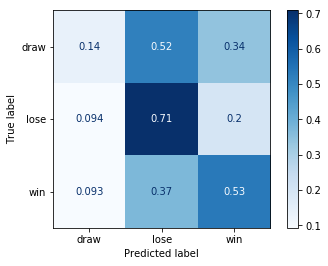

In [111]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, normalize='true', cmap='Blues')
print('auc : {0:.2%}'.format(roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovo')))
plt.show()

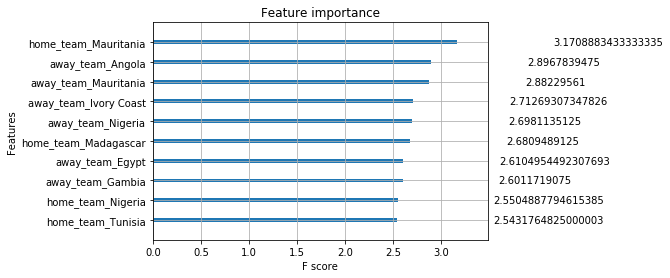

In [127]:
import xgboost as xgb

xgb.plot_importance(model, max_num_features=10, importance_type='gain')

In [47]:
from xgboost import XGBClassifier

# model
model = XGBClassifier(n_estimators=100, max_depth=2, booster='gbtree', subsample=.4, colsample_bytree=.8)
model.fit(X.values, y.values)


[11:34:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=0.4,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [49]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200, max_depth=2)

clf.fit(X, y)

RandomForestClassifier(max_depth=2, n_estimators=200)

In [50]:
import joblib
import datetime

meta_model = {
    'prject' : 'ODC Rabat Football Outcome Predictor',
    'columns' : X.columns.to_list(),
    'model' : clf,
    'matches' : 'data/matches_enhanced.csv',
    'ranking' : 'data/ranking/fifa_ranking-2021-05-27.csv'
}

joblib.dump(meta_model, 'model_rf__ODC_football_outcome_predictor_20220325__meta.model')

['model_rf__ODC_football_outcome_predictor_20220325__meta.model']

In [ ]:

meta_model = {
    'prject' : 'ODC Rabat Football Outcome Predictor',
    'columns' : X.columns.to_list(),
    'model' : clf,
    'data' : {
        'matches' : 'data/matches_enhanced.csv',
        'ranking' : 'data/ranking/fifa_ranking-2021-05-27.csv'
    }
}

In [48]:
import joblib
import datetime

meta_model = {
    'prject' : 'ODC Rabat Football Outcome Predictor',
    'columns' : X.columns.to_list(),
    'model' : model,
    'matches' : 'data/matches_enhanced.csv',
    'ranking' : 'data/ranking/fifa_ranking-2021-05-27.csv'
}

joblib.dump(meta_model, 'model_xgb__ODC_football_outcome_predictor_20220325__meta.model')

['model_xgb__ODC_football_outcome_predictor_20220325__meta.model']

In [163]:
n = random.random()

def define_outcome(n, probs, probs_class):
    
    if n < probs[0]:
        return probs_class[0]
    elif n < probs[0] + probs[1]:
        return probs_class[1]
    else:
        return probs_class[2]

In [171]:
import random

import uuid
all_games = {}

def predict(h_country, a_country):
    # create vector
    cols = X.columns

    df = pd.DataFrame(np.zeros((1,len(cols)), dtype=int), columns=cols)
    
    
    try:
        df.home_rank.iloc[0] = ranking[((ranking.rank_date == '2021-05-27') & (ranking.country_full == h_country))]['rank'].values[0]
    except:
        df.home_rank.iloc[0] = 155
        
    try:
        df.away_rank.iloc[0] = ranking[((ranking.rank_date == '2021-05-27') & (ranking.country_full == a_country))]['rank'].values[0]
    except:
        df.away_rank.iloc[0] = 155
        
    df['home_team_'+h_country].iloc[0] = 1
    df['away_team_'+a_country].iloc[0] = 1
    #df = df[hmodel.get_booster().feature_names]
    # predict
    outcome_classic = model.predict(df.iloc[0].to_numpy().reshape(1,130))[0]  
    
    n = random.random()
    probs = model.predict_proba(df.iloc[0].to_numpy().reshape(1,130))[0] 
    probs_class = ['draw', 'lose', 'win']
    outcome = define_outcome(n, probs, probs_class)
    
    
    
    if outcome == 'win':
        hscore, hval, ascore, aval = 1, 1, 0, 0
    elif outcome == 'lose':
        hscore, hval, ascore, aval = 0, 0, 1, 1
    else:
        hscore, hval, ascore, aval = 0, 0, 0, 0
        
    return h_country, a_country, [hscore, ascore], [hval, aval]

def get_match_result(foot_model, team1, team2, elimination=False):
    
    h, a, score, scored = predict(team1, team2)
    
    all_games[uuid.uuid4()] = {'team' : team1, 'opponent' : team2, 'goals_team':score[0], 'goals_opponent':score[1]}
    
    if score[0] == score[1]:
        result = 'draw'
        looser = 'draw'
    elif score[0] > score[1]:
        result = team1
        looser = team2
    else:
        result = team2
        looser = team1
        score.reverse()
        
    
    if not elimination:
        return result, looser, score
    else:
        if result != 'draw':
            return result, looser, score
        else:
            if scored[0] >= scored[1]:
                return team1, team2, score
            else:
                return team2, team1, score

In [172]:
groupA = ['Burkina Faso', 'Cape Verde', 'Cameroon', 'Ethiopia']
groupB = ['Guinea', 'Malawi', 'Senegal', 'Zimbabwe']
groupC = ['Comoros', 'Gabon', 'Ghana', 'Morocco']
groupD = ['Egypt', 'Guinea-Bissau', 'Nigeria', 'Sudan']
groupE = ['Algeria', 'Ivory Coast', 'Equatorial Guinea', 'Sierra Leone']
groupF = ['Gambia', 'Mali', 'Mauritania', 'Tunisia']
groups = [groupA, groupB, groupC, groupD, groupE, groupF]
groups_names = ['A', 'B', 'C', 'D', 'E', 'F']

In [173]:
round_16 = pd.read_csv('data/round_16/round_16.csv', sep=';')
round_16_possibilities = pd.read_csv('data/round_16/round_16_possibilities.csv', sep=';')

In [174]:
def get_group_result(foot_model, group):
    ranking = pd.DataFrame({'points':[0,0,0,0], 'diff':[0,0,0,0], 'goals':[0,0,0,0]}, index=group)
    for team1, team2 in itertools.combinations(group, 2):
        result, looser, score = get_match_result(foot_model, team1, team2)
        #print(result, '-', looser,':', score)
        if result == 'draw':
            ranking.loc[[team1, team2], 'points'] += 1
            ranking.loc[[team1, team2], 'goals'] += score[0]
        else:
            ranking.loc[result, 'points'] += 3
            ranking.loc[result, 'goals'] += score[0]
            ranking.loc[looser, 'goals'] += score[1]
            ranking.loc[result, 'diff'] += score[0]-score[1]
            ranking.loc[looser, 'diff'] -= score[0]-score[1]
            
    return ranking.sort_values(by=['points','diff','goals'], ascending=False)

def get_team(code, gr, r16p):
    if len(code)==2:
        return gr.loc[code]['name']
    else:
        return gr.loc[r16p.iloc[0][code]]['name']

def get_final_result(foot_model, groups_result, r16=round_16, r16p=round_16_possibilities):
    round_of_16 = []
    quarter_finals = []
    semi_finals = []
    
    
    # SIMULATE ROUND OF 16
    for i in range(0, 8):
        round_of_16.append(get_match_result(foot_model, 
                                            get_team(r16.iloc[i]['home_team'], groups_result, r16p), 
                                            get_team(r16.iloc[i]['away_team'], groups_result, r16p), 
                                            elimination=True))
    
    
    # SIMULATE QUATER FINALS
    quarter_finals.append(get_match_result(foot_model, round_of_16[0][0], round_of_16[2][0], elimination=True))
    quarter_finals.append(get_match_result(foot_model, round_of_16[1][0], round_of_16[3][0], elimination=True))
    quarter_finals.append(get_match_result(foot_model, round_of_16[4][0], round_of_16[6][0], elimination=True))
    quarter_finals.append(get_match_result(foot_model, round_of_16[5][0], round_of_16[7][0], elimination=True))
    
    # SIMULATE SEMI FINALS
    semi_finals.append(get_match_result(foot_model, quarter_finals[0][0], quarter_finals[2][0], elimination=True))
    semi_finals.append(get_match_result(foot_model, quarter_finals[1][0], quarter_finals[3][0], elimination=True))
    
    # SIMULATE 3RD PLACE MATCH
    little_final = get_match_result(foot_model, semi_finals[0][1], semi_finals[1][1], elimination=True)
    
    # SIMULATE FINAL
    final = get_match_result(foot_model, semi_finals[0][0], semi_finals[1][0], elimination=True)
    
    return round_of_16, quarter_finals, semi_finals, little_final, final

In [175]:
#Needed for our african CUP
groupe_stage = {}
for i in range(0, 6):
    r = get_group_result(None, groups[i])
    for k in range(1, 5):
        groupe_stage[groups_names[i]+str(k)] = {'group' : groups_names[i],
                                                'name' : r.index[k-1], 
                                                'points' : r.iloc[k-1]['points'], 
                                                'goals_difference' : r.iloc[k-1]['goals'], 
                                                'goals_scored' : r.iloc[k-1]['goals'], 
                                                'rank' : k}

combination = ''.join(list(pd.DataFrame.from_dict(groupe_stage, orient='index').query('rank==3')\
                           .sort_values(by=['points', 'goals_difference', 'goals_scored'], ascending=False).group[0:4].sort_values()))

groups_ranking = pd.DataFrame.from_dict(groupe_stage, orient='index')

In [176]:
round_of_16, quarter_finals, semi_finals, little_final, final = get_final_result(None, 
                                                                                 groups_ranking, 
                                                                                 round_16, 
                                                                                 round_16_possibilities.query('combination=="{0}"'.format(combination)))

In [193]:
MAX_EXP = 77

In [194]:
groups_rankings, round_of_16s, quarter_finalss, semi_finalss, little_finals, finals = [], [], [], [], [], []

for exp in range(0, MAX_EXP):
    groupe_stage = {}
    for i in range(0, 6):
        r = get_group_result(model, groups[i])
        for k in range(1, 5):
            groupe_stage[groups_names[i]+str(k)] = {'group' : groups_names[i],
                                                    'name' : r.index[k-1], 
                                                    'points' : r.iloc[k-1]['points'], 
                                                    'goals_difference' : r.iloc[k-1]['goals'], 
                                                    'goals_scored' : r.iloc[k-1]['goals'], 
                                                    'rank' : k}

    combination = ''.join(list(pd.DataFrame.from_dict(groupe_stage, orient='index').query('rank==3')\
                               .sort_values(by=['points', 'goals_difference', 'goals_scored'], ascending=False).group[0:4].sort_values()))

    groups_ranking = pd.DataFrame.from_dict(groupe_stage, orient='index')
    groups_ranking['try'] = 'try_' + str(exp)
    groups_rankings.append(groups_ranking)
    
    round_of_16, quarter_finals, semi_finals, little_final, final = get_final_result(model, 
                                                                                 groups_ranking, 
                                                                                 round_16, 
                                                                                 round_16_possibilities.query('combination=="{0}"'.format(combination)))
    
    d16 = pd.DataFrame(round_of_16, columns=['winner', 'loser', 'score'])
    d16['step'] = 'round_of_16'
    d16['step_'] = 16
    d16['try'] = 'try_' + str(exp)
    round_of_16s.append(d16)
    
    d8 = pd.DataFrame(quarter_finals, columns=['winner', 'loser', 'score'])
    d8['step'] = 'quarter_finals'
    d8['step_'] = 8
    d8['try'] = 'try_' + str(exp)
    quarter_finalss.append(d8)
    
    d4 = pd.DataFrame(semi_finals, columns=['winner', 'loser', 'score'])
    d4['step'] = 'semi_finals'
    d4['step_'] = 4
    d4['try'] = 'try_' + str(exp)
    semi_finalss.append(d4)

    d2 = pd.DataFrame(np.reshape(little_final, (1, 3)), columns=['winner', 'loser', 'score'])
    d2['step'] = 'little_final'
    d2['step_'] = 2
    d2['try'] = 'try_' + str(exp)
    little_finals.append(d2)
    
    d1 = pd.DataFrame(np.reshape(final, (1, 3)), columns=['winner', 'loser', 'score'])
    d1['step'] = 'final'
    d1['step_'] = 1
    d1['try'] = 'try_' + str(exp)
    finals.append(d1)

C:\Users\DevPC\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\DevPC\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [195]:
df = pd.concat(round_of_16s + quarter_finalss + semi_finalss + little_finals + finals)

In [196]:
winners = df.groupby(['step', 'step_', 'winner']).agg({'try':'count'}).reset_index().sort_values(by='step')
winners['status'] = 'win'
winners.columns = ['step', 'step_', 'country', 'try', 'status']

In [197]:
loosers = df.groupby(['step', 'step_', 'loser']).agg({'try':'count'}).reset_index().sort_values(by='step')
loosers['status'] = 'lose'
loosers.columns = ['step', 'step_', 'country', 'try', 'status']

In [198]:
tries = pd.concat([winners, loosers])

In [199]:
previous = None
for step in ['round_of_16', 'quarter_finals', 'semi_finals', 'little_final', 'final', 'win']:
    if step != 'win':
        kfka = tries.query('step=="{0}"'.format(step)).groupby('country').agg({'try':'sum'}).reset_index()
        kfka['probability_{0}'.format(step)] = kfka['try']/MAX_EXP

        if step == 'round_of_16':
            previous = kfka
        else:
            previous = kfka.merge(previous, how='outer', left_on='country', right_on='country')
    else:
        kfka = tries.query('step=="final" and status=="win"').groupby('country').agg({'try':'sum'}).reset_index()
        kfka['probability_{0}'.format(step)] = kfka['try']/MAX_EXP
        
        previous = kfka.merge(previous, how='outer', left_on='country', right_on='country')

C:\Users\DevPC\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:9203: FutureWarning: Passing 'suffixes' which cause duplicate columns {'try_y'} in the result is deprecated and will raise a MergeError in a future version.
  validate=validate,


In [200]:
previous.fillna(0)[['country'] + ['probability_'+col for col in ['round_of_16', 'quarter_finals', 'semi_finals', 'little_final', 'final', 'win']]]\
.sort_values(by=['probability_'+col for col in ['win', 'final', 'little_final', 'semi_finals', 'quarter_finals', 'round_of_16']], ascending=False)

,country,probability_round_of_16,probability_quarter_finals,probability_semi_finals,probability_little_final,probability_final,probability_win
9,Nigeria,0.948052,0.701299,0.558442,0.220779,0.337662,0.220779
10,Senegal,0.974026,0.753247,0.428571,0.155844,0.272727,0.155844
3,Egypt,0.870130,0.519481,0.363636,0.116883,0.246753,0.116883
8,Morocco,0.935065,0.701299,0.350649,0.129870,0.220779,0.116883
7,Ivory Coast,0.883117,0.493506,0.246753,0.103896,0.142857,0.103896
2,Cameroon,0.896104,0.584416,0.311688,0.090909,0.220779,0.077922
0,Algeria,0.870130,0.519481,0.259740,0.129870,0.129870,0.077922
5,Ghana,0.740260,0.337662,0.142857,0.064935,0.077922,0.038961
6,Guinea,0.662338,0.363636,0.194805,0.155844,0.038961,0.025974
12,Tunisia,0.779221,0.415584,0.194805,0.090909,0.103896,0.012987


In [202]:
dtfa = previous.fillna(0)[['country'] + ['probability_'+col for col in ['round_of_16', 'quarter_finals', 'semi_finals', 'little_final', 'final', 'win']]]\
.sort_values(by=['probability_'+col for col in ['win', 'final', 'little_final', 'semi_finals', 'quarter_finals', 'round_of_16']], ascending=False)